In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import random
import seaborn as sns
import scipy
import statsmodels.api as sm
import warnings


from pmdarima.arima import auto_arima
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [46]:
df = pd.read_excel("Series/TRM.xlsx", index_col = 'Fecha', parse_dates= True)

In [47]:
df = df.resample("M").mean()

### 2.1 Average monthly exchange rate

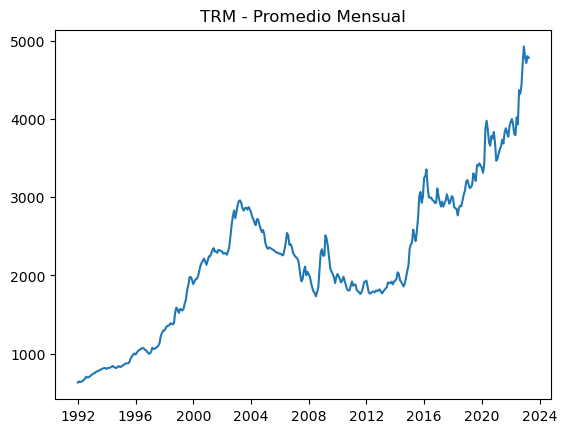

In [48]:
plt.plot(df)
plt.title('TRM - Promedio Mensual')
plt.show()

### 2.2 Returns

In [49]:
df['logs'] = np.log(df.TRM)

In [50]:
df['shift_logs'] = df.logs.shift(1)

In [51]:
df['returns']  = (df.logs - df.shift_logs)*100

In [52]:
avg_returns = df.returns.mean()

In [74]:
df.returns.describe()

count    375.000000
mean       0.540341
std        2.868717
min       -6.979288
25%       -1.277030
50%        0.406256
75%        1.972597
max       12.805317
Name: returns, dtype: float64

In [53]:
avg_returns

0.5403410052212074

### 2.3 Squared Demeaned Returns

In [54]:
df['sq_dem_ret_2'] = (df.returns - avg_returns)**2

In [58]:
df

,TRM,logs,shift_logs,returns,sq_dem_ret_2
Fecha,,,,,
1991-12-31,630.412581,6.446374,NaN,NaN,NaN
1992-01-31,644.058065,6.467789,6.446374,2.141439,2.563515
1992-02-29,635.671724,6.454682,6.467789,-1.310661,3.426209
1992-03-31,640.501935,6.462252,6.454682,0.756987,0.046935
1992-04-30,649.955000,6.476903,6.462252,1.465099,0.855177
...,...,...,...,...,...
2022-11-30,4926.660667,8.502417,8.457832,4.458497,15.351949
2022-12-31,4788.490645,8.473971,8.502417,-2.844615,11.457929
2023-01-31,4715.203871,8.458547,8.473971,-1.542310,4.337436


Text(0.5, 1.0, 'Retornos mensuales sin media al cuadrado')

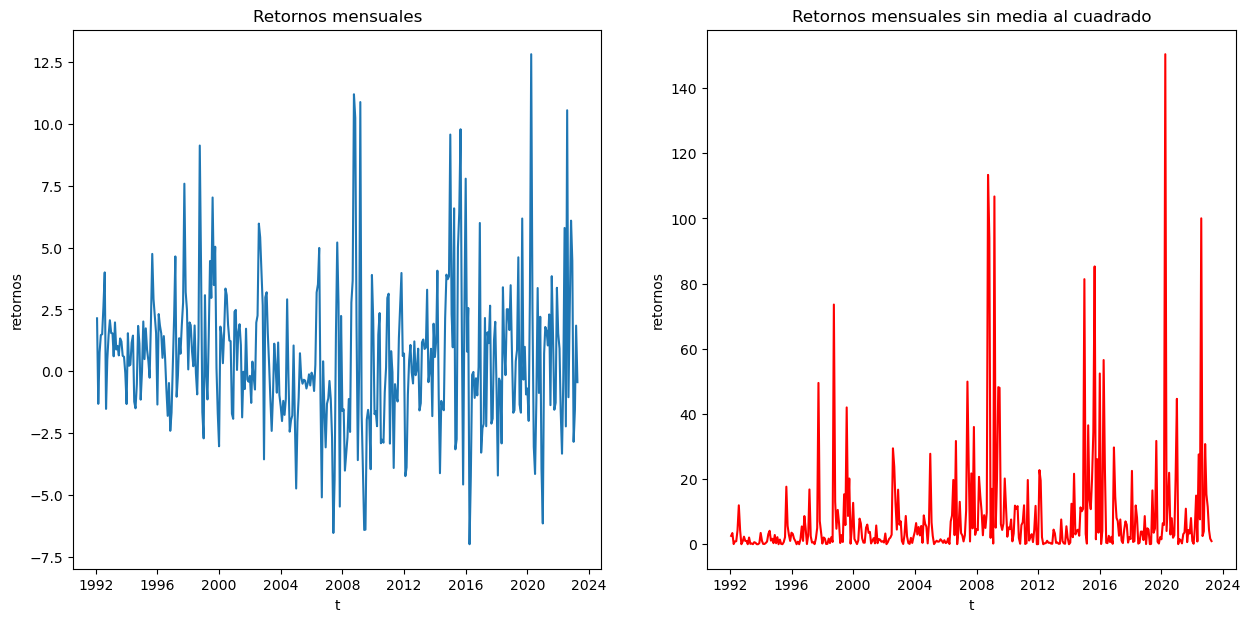

In [82]:
fig, ax =plt.subplots(1,2, figsize=(15,7), sharex = False)
sns.lineplot(data = df, y = df.returns , x = df.index, ax = ax[0])
ax[0].set_xlabel('t', fontsize=10)
ax[0].set_ylabel('retornos', fontsize=10)
ax[0].set_title('Retornos mensuales')
sns.lineplot(data = df, y = df.sq_dem_ret_2 , x = df.index, ax = ax[1], color = 'red')
ax[1].set_xlabel('t', fontsize=10)
ax[1].set_ylabel('retornos', fontsize=10)
ax[1].set_title('Retornos mensuales sin media al cuadrado')

### Cyclical component estimation

In [83]:
BM = pd.DataFrame(index = range(0,13), columns = range(0,13))
AM = pd.DataFrame(index = range(0,13), columns = range(0,13))

In [87]:
df = df.dropna()

In [88]:
for p in range(0,13): 
    for q in (range(0,13)): 
        model = ARIMA(df.sq_dem_ret_2, order=(p, 0, q)).fit() 
        BM.loc[p,q] = round(model.bic, 2) 
        AM.loc[p,q] = round(model.aic, 2)

/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters f

In [91]:
AMM = AM.to_numpy() 
MinAIC = AMM.min() 
MinAIC_pq = np.where(AMM == MinAIC) 
MinAIC_pq

(array([8]), array([0]))

In [92]:
BMM = BM.to_numpy() 
MinBIC = BMM.min() 
MinBIC_pq = np.where(BMM == MinBIC)
MinBIC_pq

(array([1]), array([1]))

In [93]:
model = auto_arima(df.sq_dem_ret_2, 
    start_p = 0, max_p = 12, #rango de p
    d = 0, max_d = 1, #rango de diferenciación
    start_q = 0,  max_q = 12, #rango de q
    information_criterion="bic", #criterio de selección
    with_intercept = True, #intercepto
    stepwise = False, 
    method = "lbfgs",
    seasonal = False,
    trace = 1)

 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=3195.902, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=3194.493, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=3199.002, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : BIC=3203.316, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : BIC=3203.200, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : BIC=3205.499, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=3193.495, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=3184.858, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=3190.783, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : BIC=3194.965, Time=0.28 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : BIC=3199.418, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=3197.657, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=3190.784, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=3196.324, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : BIC=3202.197, Time=0.35 sec
 ARIMA(3,0